In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import networkx as nx

In [2]:
from nbhd import data

In [3]:
db = data.Base()

Initializing database connection...
Database connected!


In [4]:
def get_communities(db,
                    polygon, 
                    residential_street_threshold=30,
                    short_threshold=10,
                    snap_nodes_threshold=0,
                    quiet=True):
    '''
    Get networks of connected residential street communities.
    '''
    # first we need all the roads in the polygon, so that those without
    # a nearby property don't get missed out.
    
    if not quiet:
        print('First getting all roads in polygon...')
    all_streets = db.intersects('roads', polygon)
    if not quiet:
        print(f'That is {len(all_streets)} road segments in total!')
    
    if not quiet:
        print('Now marking whether they are residential...')
    residential_streets, properties = get_residential_streets_and_properties(
        db, polygon, residential_street_threshold)
    if not quiet:
        print((f'{len(residential_streets.loc[residential_streets.residential])}'
               ' are residential.'))
     
    streets = pd.concat([all_streets.rename({'id':'roads_id'},axis=1),
                         residential_streets], keys='roads_id', join='outer')
    streets['short'] = (streets.geometry.length < short_threshold)
    streets['short_or_residential'] = (streets.residential | streets.short)
    
    if snap_nodes_threshold > 0:
        if not quiet:
            print('Now snapping nearby nodes together...')
        snap_together_nearby_nodes(streets)

    if not quiet:
        print('Now labelling connected communities...')
    streets, properties = label_connected_communities(
        streets, properties)
    community_size_dict = dict(streets.community.value_counts())
    streets['community_size'] = streets.community.apply(
        lambda x: community_size_dict.get(x,0))
    properties['faceblock_community_size'] = properties.community.apply(
            lambda x: community_size_dict.get(x,0))

    return streets, properties

In [5]:
def get_residential_streets_and_properties(db, polygon, residential_street_threshold):
    '''
    Return dataframe of streets marked `short_or_residential`.
    '''
    properties_on_streets_df = get_properties_on_streets(db, polygon)
    properties_on_streets_df['residential'] = mark_residential_properties(
        properties_on_streets_df, db, polygon)
    
    residential_properties_df = properties_on_streets_df.loc[properties_on_streets_df.residential]
    # the `roads_id` is repeated every time a property has it as nearest road
    property_counts_dict = dict(residential_properties_df.roads_id.value_counts())

    # we can now ignore the individual properties and focus on the streets
    streets = properties_on_streets_df[
        ~properties_on_streets_df.roads_geometry.duplicated()][
        ['roads_id','startNode','endNode','roads_geometry']]
    streets['number_of_properties'] = streets.roads_id.apply(
        lambda roads_id: property_counts_dict.get(roads_id, 0))
    
    # convert to GeoDataFrame
    streets = gpd.GeoDataFrame(streets, geometry=gpd.GeoSeries.from_wkb(streets.roads_geometry))
    streets['length_per_property'] = streets.geometry.length / streets.number_of_properties
    streets['residential'] = (streets.length_per_property < residential_street_threshold)
   
    return (streets, 
            gpd.GeoDataFrame(residential_properties_df,
                            geometry=gpd.GeoSeries.from_wkb(
                                residential_properties_df.properties_geometry)))

In [6]:
def get_properties_on_streets(db, polygon):
    
    return db.knn('properties', 'roads', polygon,
               t2_columns=['"startNode"', '"endNode"'])

In [7]:
def mark_residential_properties(properties, db, polygon):
    df = properties.copy()
    # we say a property is residential if it is in a building
    properties_in_buildings = get_properties_in_buildings(db, polygon)
    
    properties_in_buildings['residential'] = mark_residential_buildings(
        properties_in_buildings)
   
    df['residential'] = df.properties_id.apply(
        lambda properties_id: properties_id 
        in properties_in_buildings.loc[
            properties_in_buildings.residential].properties_id.values)
    return df.residential

In [8]:
def get_properties_in_buildings(db, polygon):
    
    # query db for nearest building for each property in polygon
    df = db.knn('properties', 'buildings', polygon)
    
    # if a property is in a building, then the distance
    # between it and its nearest building is 0
    return df.loc[df.dist==0]

In [9]:
def mark_residential_buildings(properties_in_buildings_df):
    
    df = properties_in_buildings_df.copy()
    
    # TODO: write logic to distinguish residential buildings
    # idea 1. footprint per property must be under threshold.
    # idea 2. institutional buildings will be labelled by `names`.
    
    # but for the moment we'll just say that for everything
    df['residential_building'] = True
    
    return df.residential_building


In [10]:
def snap_together_nearby_nodes(streets_df):
    
    # logic to snap together nearby nodes
    
    return streets_df
    

In [11]:
def label_connected_communities(all_streets_df, properties_df):
    
    # we want to find connected communities of streets that are short or residential
    streets_df = all_streets_df.loc[all_streets_df.short_or_residential]
    street_graph = nx.from_pandas_edgelist(streets_df, 'startNode', 'endNode', True)
    subgraphs = [street_graph.subgraph(component) for component in nx.connected_components(street_graph)]

    communities = { 
        str(i+1).zfill(3):
             list(nx.get_edge_attributes(graph, 'roads_id').values()) 
             for i, graph in enumerate(subgraphs)}

    communities_key = {
        value : key
        for key, value_list in communities.items() for value in value_list
    }
    all_streets_df['community'] = all_streets_df.roads_id.apply(lambda street_id: communities_key.get(street_id, None))
    properties_df['community'] = properties_df.roads_id.apply(lambda street_id: communities_key.get(street_id, None))
    
    
    return all_streets_df, properties_df

In [12]:
here = db.query("SELECT geometry FROM names WHERE name1='CB4 2SY'",True)

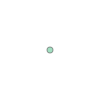

In [13]:
here.geometry[0]

In [14]:
p = db.intersects('pixels',here.geometry[0])

In [15]:
pixel = p.geometry[0]

In [16]:
settings = {'footprint_threshold':1000,
            'res_length_threshold':30,
            'short_threshold':0,
            'node_distance':5,
           'min_community_size':10}

In [17]:
streets, properties = get_communities(db, pixel, residential_street_threshold=20, quiet=False)

First getting all roads in polygon...
That is 712 road segments in total!
Now marking whether they are residential...
497 are residential.
Now labelling connected communities...


<AxesSubplot:>

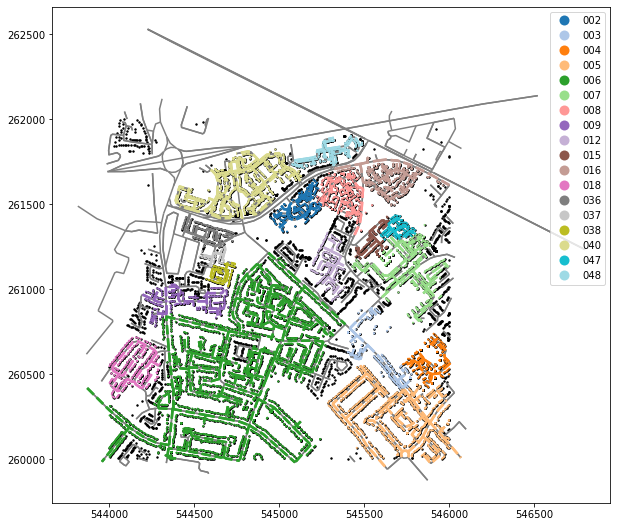

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
streets.plot(ax=ax, color='grey')
streets.loc[streets.community_size > 10].plot('community', ax=ax, linewidth=2.5, linestyle='--', legend=True, cmap='tab20')
properties.plot(color='k', ax=ax, markersize=2)
properties.loc[properties.faceblock_community_size > 10].plot('community', ax=ax, markersize=1, cmap='tab20')